# Self-Balancing Scooter Control

![](images/self-balancing-scooter.png)

> A self-balancing scooter [...] is a self-balancing personal transporter consisting of two motorized wheels connected to a pair of articulated pads on which the rider places their feet. The rider controls the speed by leaning forward or backward, and direction of travel by twisting the pads.
> 
> Source: <https://en.wikipedia.org/wiki/Self-balancing_scooter>

### Python Dependencies

In [26]:
from numpy import *
from numpy.linalg import *

from scipy.linalg import *
from scipy.integrate import *
from scipy.signal import *

from matplotlib.pyplot import *

Step 1 - Scooter Planar Model
================================

### Introduction

We consider a simple model of a self-balancing scooter evolving in the plane. It is mainly made of

  - The frame that contains the two articulated pads; from above, each pad essentially look like a triangle (one vertice in the center of the frame, one vertice at each extremity of the wheel).

  - Two fixed wheels (their orientation with respect to the frame does not change). 
    They are parallel and located at opposite ends of the frame. 
    
Let $(0, e_x, e_y)$ be a direct orthonormal frame of the plane. We denote 

  - $(x, y)$ the coordinates of the wheel axis center in the orthonormal and 
  - $\theta$ the angle of the wheels direction with respect to vector $e_x$ ; with $\theta = 0$ when the front of the scooter faces the right ($e_x$) and $\theta = \pi/2$ when it faces upwards ($e_y$).

  - $\phi_l$ and $\phi_r$ the rotation angles of the left and right wheel respectively ; by convention, when these angles increase, the scooter moves forward.

### Parameter Definition

From now on, we assume that the seat frame length is $\ell = 50 \text{ cm}$ and the wheel radius is $r = 12.5 \text{ cm}$.

🧩 Define the corresponding Python variables `l` and `r` (express every length in meters, and more generally in the sequel, always use the [international standard of units](https://en.wikipedia.org/wiki/SI_derived_unit)) for numerical values. 

In [27]:
l = 0.5
r = 0.125

### Graphical Representation

🧩 Implement a function `draw_scooter` with arguments `x`, `y` and `theta` that draws a simple geometric model of the wheelchair (with a red frame and black fixed wheels) in the plane (top view) for arbitrary values of $(x, y)$ and $\theta$. Use a green circle marker 50 cm in of the frame to indicate which way is forward.

🗝️ **Hint.** Use the function `plot` of `matplotlib.pyplot`.

In [28]:
def draw_scooter(x, y, theta):

    #Coordonates of the center of the right wheel
    x1 = x + sin(theta)*l/2
    y1 = y - cos(theta)*l/2

    #Coordonates of the center of the left wheel
    x2 = x - sin(theta)*l/2
    y2 = y + cos(theta)*l/2

    #Coordinates of the front and back of the right wheel
    xr_1 = x1 - r*cos(theta)
    xr_2 = x1 + r*cos(theta)
    yr_1 = y1 - r*sin(theta)
    yr_2 = y1 + r*sin(theta)

    #Coordinates of the front and back of the left wheel
    xl_1 = x2 - r*cos(theta)
    xl_2 = x2 + r*cos(theta)
    yl_1 = y2 - r*sin(theta)
    yl_2 = y2 + r*sin(theta)

    # Right wheel
    xr = linspace(xr_1, xr_2)
    yr = linspace(yr_1, yr_2)
    #Left wheel
    xl = linspace(xl_1, xl_2)
    yl = linspace(yl_1, yl_2)

    # Plot wheels as thick lines
    plot(xr, yr, 'k-', linewidth = 4)
    plot(xl, yl, 'k-', linewidth = 4)


    # Plot pads (triangles)
    fill([xr_1, xr_2, x, xr_1], [yr_1, yr_2, y, yr_1], 'r-')  # Right pad
    fill([xl_1, xl_2, x, xl_1], [yl_1, yl_2, y, yl_1], 'r-')  # Left pad

    # Green marker
    x_m = x + 0.5*cos(theta)
    y_m = y + 0.5*sin(theta)
    
    circle = Circle((x_m, y_m), 0.03, color='green', fill=True)
    # Add the circle patch to the plot
    gca().add_patch(circle)


🧩 Represent the wheelchair when $(x, y, \theta) = (0, 0, 0), (2, 2, \pi/2), (0, 4, \pi), (-2, 2, 3\pi/2)$.

🗝️ **Hint.** Use the following `draw_arena` function beforehand.

In [29]:
def draw_arena(xmin, xmax, ymin, ymax):
    wh_ratio = (xmax - xmin) / (ymax - ymin)
    figsize = fig_width, fig_height = 16, 16 / wh_ratio
    figure(figsize=figsize)
    axes = gca()
    axes.axis([xmin, xmax, ymin, ymax])
    axes.set_aspect(1)
    xticks(arange(xmin, xmax+1, 1))
    yticks(arange(ymin, ymax+1, 1))
    grid(True)

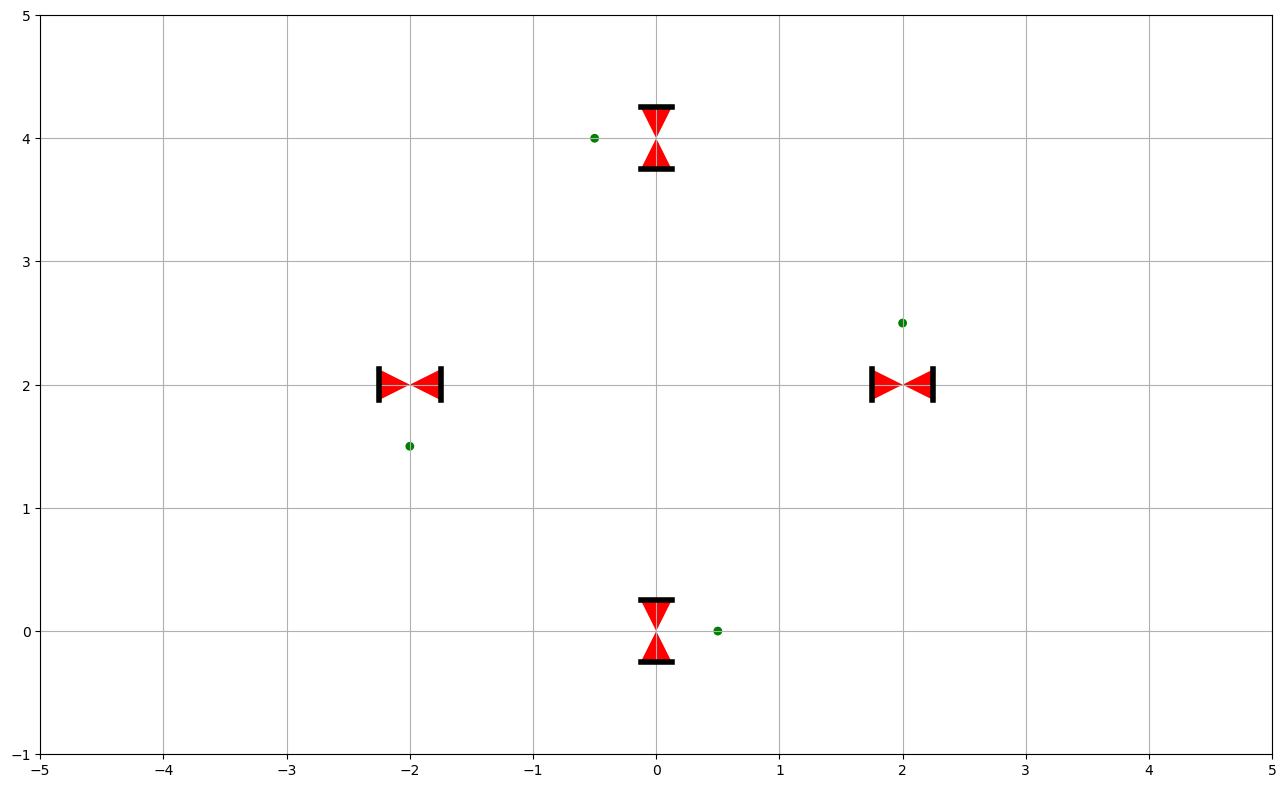

In [30]:
draw_arena(-5, 5, -1, 5)
draw_scooter(0,0,0)
draw_scooter(2, 2, pi/2)
draw_scooter(0, 4, pi)
draw_scooter(-2, 2, 3*pi/2)

### Kinematic Modeling

We assume that we can control the wheels angular velocities $\omega_l = \dot{\phi}_l$ and $\omega_r = \dot{\phi}_r$ (this is a *kinematic* model of the wheelchair).
We also assume that the wheelchair fixed wheels roll without slipping. 

🧩 Establish the differential equations that relate $\dot{x}$,
$\dot{y}$ and $\dot{\theta}$ with $\omega_l$ and $\omega_r$.

**Answer**

The linear velocities of both wheels are given by: $V_l = r.\omega_l$ and $V_r = r.\omega_r$. While the velocity of the center of mass of the scooter is :
$$
V = \frac{1}{2}(V_l+V_r)=\frac{r}{2}(\omega_l+\omega_r)
$$.

Knowing that $\dot x = V_x = Vcos(\theta)$, $\dot y = V_y=Vsin(\theta)$ and $\dot \theta = \frac{r}{\ell}( \omega_r-\omega_l)$, where $\dot x$ is the $x$ component of the velocity of the scooter, $\dot y$ its $y$ component, and $\dot \theta$ the angular momentum of the scooter, we can write the differentiel equations that relate them to $\omega_l$ and $\omega_r$:

$$
\begin{align*}
\dot{\theta} &= \frac{r}{\ell} (\omega_r - \omega_l) \\
\dot{x} &= \frac{r}{2} \cos(\theta)(\omega_r + \omega_l) \\
\dot{y} &= \frac{r}{2} \sin(\theta)(\omega_r + \omega_l)
\end{align*}
$$

### Analysis

🧩 Show that if $\omega_l$ and $\omega_r$ are continuously differentiable functions of $(x, y, \theta)$ (which includes the case of constant inputs), this system is well-posed.

**Answer**

When we model this problem as a vector field, each possible initial condition corresponds to a unique vector in the vector field. Because the vector field is continuously differentiable, the existence and uniqueness theorem for ordinary differential equations guarantee that there is exactly one trajectory passing through each point in the initial condition space. In other words, for any given initial condition, there exists a unique solution to the system of differential equations. So, indeed, the system is well-posed.

🧩 Show that if $\omega_l$ and $\omega_r$ are constants, the maximal solution associated to any initial state is global. Is is still true of $\omega_l$ and $\omega_r$ are arbitrary continuously differentiable functions of $(x, y, \theta)$ ?

**Answer**

<u>Case 1: $\omega_l$ and $\omega_r$ are constants:</u>

When $\omega_l$ and $\omega_r$ are constants, the system of equations becomes time-independent, and we essentially have a set of autonomous ordinary differential equations. In this case, the solution trajectory is uniquely determined and extends for all time $t$. Therefore, the maximal solution associated with any initial state is indeed global.

<u>Case 2: $\omega_l$ and $\omega_r$ are arbitrary continuously differentiable functions of $(x, y, \theta)$:</u>

When $\omega_l$ and $\omega_r$ are arbitrary continuously differentiable functions of $(x, y, \theta)$, the system becomes time-dependent, and the solution trajectories may vary depending on the functions $\omega_l$ and $\omega_r$ as well as the initial conditions.

Let's take an example where : $\omega_r = -\omega_l = \alpha\theta^2 + \beta\theta +\gamma$. $\alpha$, $\beta$ and $\gamma$ being constants.

Now, let's suppose we have initial conditions $(x_0, y_0, \theta_0)$, where $\theta_0 \neq 0$, and $x_0 = y_0 = 0$.

The differential equations become:

$$\dot{x} = \frac{r}{2}(\omega_r + \omega_l)\cos(\theta) = 0$$

$$\dot{y} = \frac{r}{2}(\omega_r + \omega_l)\sin(\theta) = 0$$

$$\dot{\theta} = \frac{r}{L}(\omega_r - \omega_l) = 2\frac{r}{L}(\alpha\theta^2 + \beta\theta +\gamma)$$

Since $\dot{x}$ and $\dot{y}$ are both zero, the position remains constant at the origin. However, $\dot{\theta}$, the angular velocity, will depend quadratically on $\theta$, leading to potentially divergent behavior. Which means that a global solution doesn't exist.

### Vector Field

In the sequel, `omega` is a function that computes the input vector $\omega := (\omega_l, \omega_r)$ given the time $t$ and $(x, y, \theta)$ (thus, it may depend on the time and/or on the system state if needed). For example:

In [31]:
def omega(t, xytheta):
    omega_l = (1 - l/4) * pi / r
    omega_r = (1 + l/4) * pi / r
    return array([omega_l, omega_r])

🧩 Implement a function `fun(t, xytheta)` that computes $(\dot{x}, \dot{y}, \dot{\theta})$ given the time $t$ and $(x,y,\theta)$ (and implicitly the inputs $\omega$ computed by the function `omega`).

In [32]:
def fun(t, xytheta) :
    x, y, theta = xytheta
    omega_l, omega_r = omega(t, xytheta)
    dtheta = r/l * (omega_r - omega_l)
    dx = r/2 * cos(theta) * (omega_r+omega_l)
    dy = r/2 * sin(theta) * (omega_r+omega_l)
    return array([dx, dy,dtheta])

### Simulation Setup

🧩 Simulate the wheelchair dynamics for 4 seconds when $(x_0, y_0, \theta_0)(t=0) = (0.0, 0.0, 0.0)$,
and the wheels velocities are the constants $\omega_l = (1 - \ell/4)  \pi / r \text{ rad/s}$ and $\omega_r = (1 + \ell/4)  \pi / r \text{ rad/s}$.
(Compute the dense outputs.)
   

In [33]:
simul = solve_ivp(fun=fun, t_span =(0.0, 4.0), y0=[0.0, 0.0, 0.0], dense_output=True)

🧩 Use the simulation results to draw the graphs of $x(t)$, $y(t)$ and $\theta(t)$.

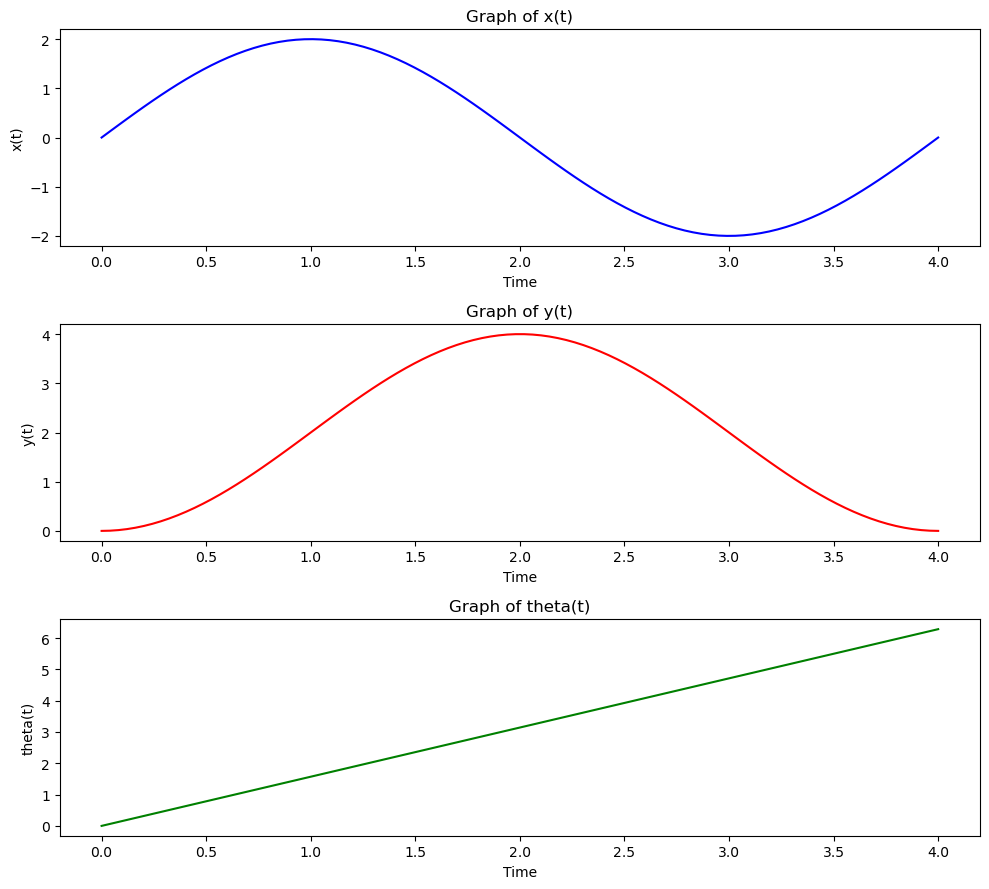

In [42]:
# Extracting the solution
t = linspace(0.0, 4.0, 100)
x_t, y_t, theta_t = simul["sol"](t)

# Plotting
figure(figsize=(10, 9))

subplot(3, 1, 1)
plot(t, x_t, 'b-')
xlabel('Time')
ylabel('x(t)')
title('Graph of x(t)')

subplot(3, 1, 2)
plot(t, y_t, 'r-')
xlabel('Time')
ylabel('y(t)')
title('Graph of y(t)')

subplot(3, 1, 3)
plot(t, theta_t, 'g-')
xlabel('Time')
ylabel('theta(t)')
title('Graph of theta(t)')

tight_layout()
show()

🧩 Use the simulation results to display the robot location every 0.5 second.

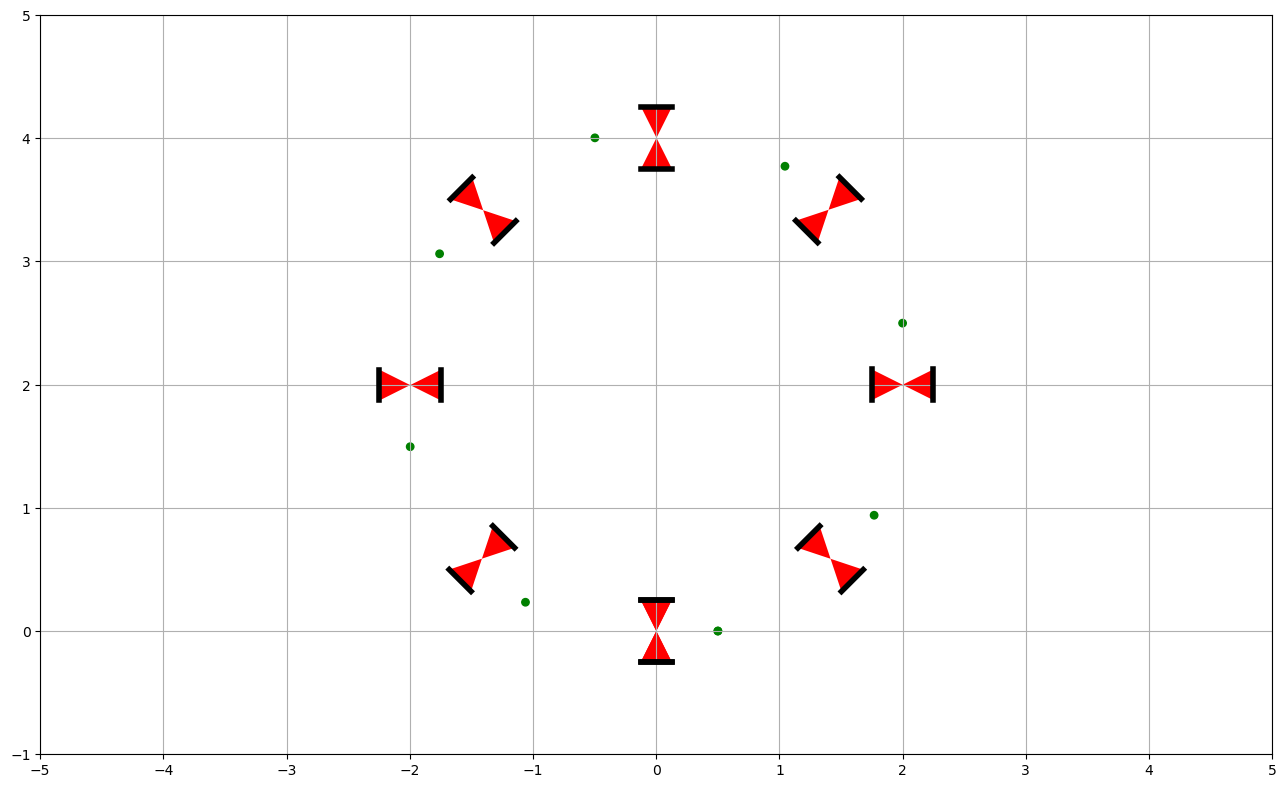

In [35]:
t = linspace(0.0, 4.0, 9)
draw_arena(-5, 5, -1, 5) 
for x, y, theta in simul["sol"](t).T :
    draw_scooter(x, y, theta)

🧩 What should be the analytical expression of $x(t)$, $y(t)$ and $\theta(t)$? 

**Answer**

The analytical expressions for $x(t)$, $y(t)$, and $\theta(t)$ can be derived from the differential equations we obtained earlier:

$$
\begin{align*}
\dot{\theta} &= \frac{r}{\ell} (\omega_r - \omega_l) \\
\dot{x} &= \frac{r}{2} \cos(\theta)(\omega_r + \omega_l) \\
\dot{y} &= \frac{r}{2} \sin(\theta)(\omega_r + \omega_l)
\end{align*}
$$

Given the values of $\omega_l$ and $\omega_r$:

$$
\begin{align*}
\omega_l &= (1-\frac{\ell}{4})\frac{\pi}{r}\\
\omega_r &= (1+\frac{\ell}{4})\frac{\pi}{r}
\end{align*}
$$

We get :

$$
\begin{align*}
\omega_r + \omega_l &= \frac{2\pi}{r}\\
\omega_r - \omega_l &= \frac{\pi \ell}{2r}
\end{align*}
$$

And since $\omega_l$ and $\omega_r$ are constants, we can then simply integrate the differential equations to get:

$$
\begin{align*}
\theta(t) &= \theta_0 + \frac{\pi}{2}t \\
x(t) &= c_1 + 2\sin(\theta_0 + \frac{\pi}{2}t) \\
y(t) &= c_2 - 2\cos(\theta_0 + \frac{\pi}{2}t)
\end{align*}
$$

Where $c_1$ and $c_2$ are integration constants. And now using the initial conditions $(x_0, y_0, \theta_0)(t=0) = (0, 0, 0)$, we get the analytical expressions:

$$
\begin{align*}
\theta(t) &= \frac{\pi}{2}t \\
x(t) &= 2 \sin(\frac{\pi}{2}t) \\
y(t) &= - 2 \cos(\frac{\pi}{2}t) +2
\end{align*}
$$

🧩 Do you experimental results match the theoretical results ? Draw the curves of the simulation error at time $t$ for $x$, $y$ and $\theta$.

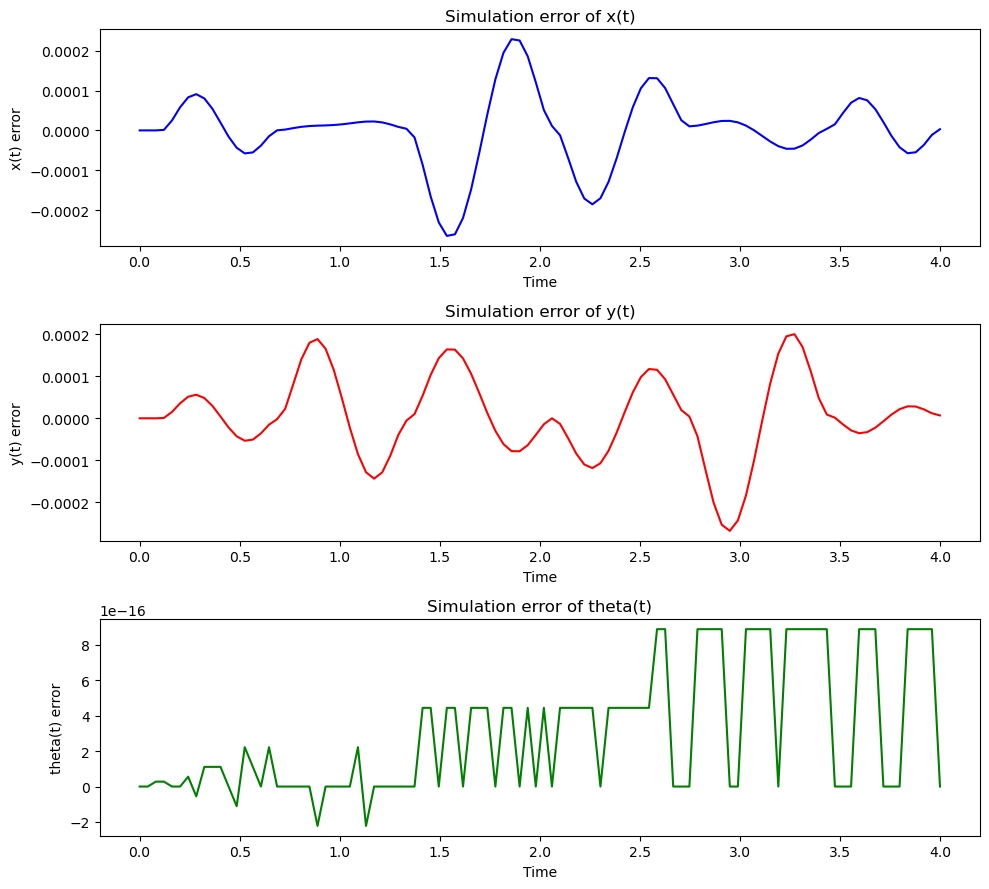

In [44]:
# Extracting the solution
t = linspace(0.0, 4.0, 100)
x_t, y_t, theta_t = simul["sol"](t)

# Plotting
figure(figsize=(10, 9))

subplot(3, 1, 1)
plot(t , x_t - 2*sin(pi*t/2), 'b-')
xlabel('Time')
ylabel('x(t) error')
title('Simulation error of x(t)')

subplot(3, 1, 2)
plot(t , y_t + 2*cos(pi*t/2)-2, 'r-')
xlabel('Time')
ylabel('y(t) error')
title('Simulation error of y(t)')

subplot(3, 1, 3)
plot(t, theta_t - (pi / 2)*t, 'g-')
xlabel('Time')
ylabel('theta(t) error')
title('Simulation error of theta(t)')

tight_layout()
show()

🧩 If needed, adjust the simulation parameters the simulated position error is less than $1\, \mathrm{ mm}$. 

Simulation successful with rtol=1e-05 and atol=1e-05. Max error: 0.000312


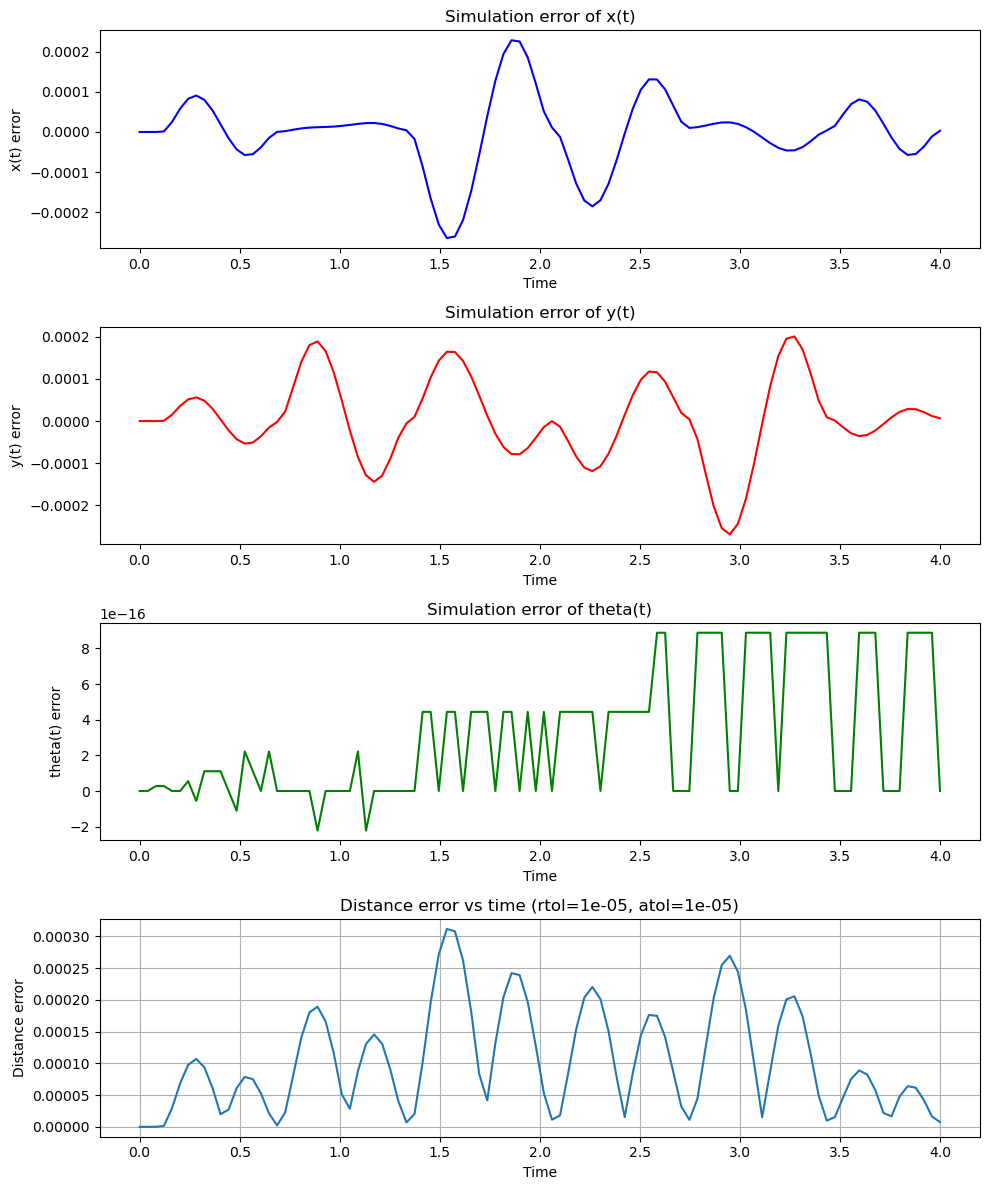

In [47]:
# We will iterate over different parameters until desired accuracy is achieved
desired_accuracy = 1e-3  # 1 mm
for rtol in [1e-4, 1e-5, 1e-6, 1e-7]:
    for atol in [1e-4, 1e-5, 1e-6, 1e-7]:
        simul = solve_ivp(fun=fun, t_span=(0.0, 4.0), y0=[0.0, 0.0, 0.0], dense_output=True, rtol=rtol, atol=atol)
        t = linspace(0.0, 4.0, 100)
        x_t, y_t, theta_t = simul["sol"](t)
        # Define the analytical solution
        x_analytical = 2 * sin(pi * t / 2)
        y_analytical = -2 * cos(pi * t / 2) + 2
        # Calculate errors
        distance_error = sqrt((x_t - x_analytical)**2 + (y_t - y_analytical)**2)
        # Calculate maximum error
        max_error = max(distance_error)
        if max_error < desired_accuracy:
            print(f"Simulation successful with rtol={rtol} and atol={atol}. Max error: {max_error:.6f}")
            # Plotting
            figure(figsize=(10, 12))

            subplot(4, 1, 1)
            plot(t , x_t - 2*sin(pi*t/2), 'b-')
            xlabel('Time')
            ylabel('x(t) error')
            title('Simulation error of x(t)')

            subplot(4, 1, 2)
            plot(t , y_t + 2*cos(pi*t/2)-2, 'r-')
            xlabel('Time')
            ylabel('y(t) error')
            title('Simulation error of y(t)')

            subplot(4, 1, 3)
            plot(t, theta_t - (pi / 2)*t, 'g-')
            xlabel('Time')
            ylabel('theta(t) error')
            title('Simulation error of theta(t)')

            subplot(4, 1, 4)
            plot(t, distance_error)
            xlabel('Time')
            ylabel('Distance error')
            title(f'Distance error vs time (rtol={rtol}, atol={atol})')
            grid(True)

            tight_layout()
            show()
            break
    else:
        continue
    break